In [ ]:
## Function to extract zip file
from zipfile import ZipFile 


def extract_zip(input_path):
  with ZipFile(input_path,'r') as zip:
    zip.extractall()
    print('Done!')

In [ ]:
extract_zip("/content/drive/MyDrive/Anime to Real Face.zip")

Done!


In [ ]:
# example of preparing the horses and zebra dataset
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(128,128)):
  data_list = list()
  # enumerate filenames in directory, assume all are images
  for filename in listdir(path):
    # load and resize the image
    pixels = load_img(path + filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # store
    data_list.append(pixels)
  return asarray(data_list)

  
# load dataset A
dataA = load_images('/content/Anime to Real Face/Anime/Formatted Selected Animes Zip/')
print( 'Loaded dataA: ' , dataA.shape)
# load dataset B
dataB = load_images('/content/Anime to Real Face/1193 Matted Faces/Matted Faces/')
print( 'Loaded dataB: '  , dataB.shape)
# save as compressed numpy array
filename =  'anime2real_128.npz'
savez_compressed(filename, dataA, dataB)
print( 'Saved dataset: '  , filename)

Loaded dataA:  (1712, 128, 128, 3)
Loaded dataB:  (1138, 128, 128, 3)
Saved dataset:  anime2real_128.npz


Loaded:  (1712, 100, 100, 3) (1138, 100, 100, 3)


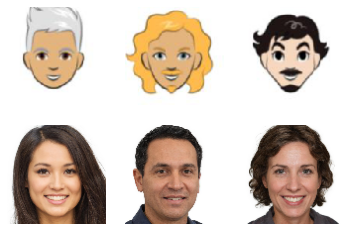

In [ ]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the face dataset
data = load( 'anime2real_128.npz' )
dataA, dataB = data[ 'arr_0' ], data[ 'arr_1' ]
print( 'Loaded: '  , dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
  pyplot.subplot(2, n_samples, 1 + i)
  pyplot.axis( 'off' )
  pyplot.imshow(dataA[i].astype( 'uint8' ))
# plot target image
for i in range(n_samples):
  pyplot.subplot(2, n_samples, 1 + n_samples + i)
  pyplot.axis( 'off' )
  pyplot.imshow(dataB[i].astype( 'uint8' ))
pyplot.show()

In [ ]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-dmq0ua9i
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-dmq0ua9i
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=31ae1966a2597f8ad1067a057f91ffdc86fb9bd477cec7a59e5e3cf386eeba4a
  Stored in directory: /tmp/pip-ephem-wheel-cache-bec9tj5w/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
# example of training a cyclegan with Semantic Loss
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU, BatchNormalization, Dropout, Reshape
from keras.layers import Activation
from keras.layers import Concatenate, Flatten, Dense
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
import numpy as np

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # source image input
  in_image = Input(shape=image_shape)
  # C64
  d = Conv2D(64, (4,4), strides=(2,2), padding= 'same' , kernel_initializer=init)(in_image)
  d = LeakyReLU(alpha=0.2)(d)
  # C128
  d = Conv2D(128, (4,4), strides=(2,2), padding= 'same' , kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C256
  d = Conv2D(256, (4,4), strides=(2,2), padding= 'same' , kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # # C512
  # d = Conv2D(512, (4,4), strides=(2,2), padding= 'same' , kernel_initializer=init)(d)
  # d = InstanceNormalization(axis=-1)(d)
  # d = LeakyReLU(alpha=0.2)(d)
  #second last output layer
  d = Conv2D(512, (4,4), padding= 'same' , kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # patch output
  patch_out = Conv2D(1, (4,4), padding= 'same' , kernel_initializer=init)(d)
  # define 
  model = Model(in_image, patch_out)
  # compile model
  model.compile(loss= 'mse' , optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
  return model

# define the discriminator model 17 patch Disc
def define_discriminator_3(image_shape):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # source image input
  in_image = Input(shape=image_shape)
  # # C64
  # d = Conv2D(64, (4,4), strides=(2,2), padding= 'same' , kernel_initializer=init)(in_image)
  # d = LeakyReLU(alpha=0.2)(d)
  # C128
  d = Conv2D(128, (4,4), strides=(2,2), padding= 'same' , kernel_initializer=init)(in_image)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C256
  d = Conv2D(256, (4,4), strides=(2,2), padding= 'same' , kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # # C512
  # d = Conv2D(512, (4,4), strides=(2,2), padding= 'same' , kernel_initializer=init)(d)
  # d = InstanceNormalization(axis=-1)(d)
  # d = LeakyReLU(alpha=0.2)(d)
  # second last output layer
  d = Conv2D(512, (4,4), padding= 'same' , kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # patch output
  patch_out = Conv2D(1, (4,4), padding= 'same' , kernel_initializer=init)(d)
  # define 
  model = Model(in_image, patch_out)
  # compile model
  model.compile(loss= 'mse' , optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
  return model

# define the discriminator model
def define_discriminator_2(image_shape):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # source image input
  in_image = Input(shape=image_shape)
  # C64
  d = Conv2D(16, (4,4), strides=(2,2), padding= 'same' , kernel_initializer=init)(in_image)
  d = LeakyReLU(alpha=0.2)(d)
  # C128
  d = Conv2D(32, (4,4), strides=(2,2), padding= 'same' , kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C256
  d = Conv2D(32, (4,4), strides=(2,2), padding= 'same' , kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C512
  d = Conv2D(32, (4,4), strides=(2,2), padding= 'same' , kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Flatten()(d)
  d = Dense(1,activation='sigmoid')(d)
 
  model = Model(in_image,d)
  # compile model
  model.compile(loss= 'mse' , optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
  return model

In [ ]:
def encoder(image_shape=(64,64,3)):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # image input (64,64,3)
  in_image = Input(shape=image_shape)
  # (32,32,32)
  g = Conv2D(32, (3,3), strides=(2,2), padding= 'same' , kernel_initializer=init)(in_image)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # (16,16,64)
  g = Conv2D(64, (3,3), strides= (2,2), padding= 'same' , kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # (8,8,128)
  g = Conv2D(128, (3,3),strides=(2,2), padding= 'same' , kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # (4,4,256)
  g = Conv2D(256, (3,3),strides=(2,2), padding= 'same' , kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)

  g = Flatten()(g)
  g = Dense(1024,activation='sigmoid')(g)
  g = Reshape((1,1,1024))(g)

  model = Model(in_image,g)
  return model

In [ ]:
def decoder(image_shape=(1,1,1024)):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # image input (1024)
  in_image = Input(shape=(image_shape))
  # u512
  g = Conv2DTranspose(512, (3,3), strides=(4,4), padding= 'same' , kernel_initializer=init)(in_image)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # u256
  g = Conv2DTranspose(256, (3,3), strides=(2,2), padding= 'same' , kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # u128
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding= 'same' , kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # u64
  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding= 'same' , kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # u3
  g = Conv2DTranspose(3, (3,3), strides=(2,2), padding= 'same' , kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'tanh' )(g)

  # define model
  model = Model(in_image, g)
  return model
  


In [ ]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # first layer convolutional layer
  g = Conv2D(n_filters, (3,3), padding= 'same' , kernel_initializer=init)(input_layer)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # second convolutional layer
  g = Conv2D(n_filters, (3,3), padding= 'same' , kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  # concatenate merge channel-wise with input layer
  g = Concatenate()([g, input_layer])
  return g


def encoder_2(image_shape):
  # weight initialization
  n_resnet = 3
  init = RandomNormal(stddev=0.02)
  # image input
  in_image = Input(shape=image_shape)
  # c7s1-64
  g = Conv2D(64, (7,7), padding= 'same' , kernel_initializer=init)(in_image)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # d128
  g = Conv2D(128, (3,3), strides=(2,2), padding= 'same' , kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # d256
  g = Conv2D(256, (3,3), strides=(2,2), padding= 'same' , kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # 
  for _ in range(n_resnet):
    g = resnet_block(256, g)
  model = Model(in_image,g)
  return model

In [ ]:
def decoder_2(encoder):
  image_shape = encoder.output_shape[1:]
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # image input (1024)
  in_tensor = Input(shape=(image_shape))
  # u128
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding= 'same' , kernel_initializer=init)(in_tensor)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # u64
  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding= 'same' , kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation( 'relu' )(g)
  # c7s1-3
  g = Conv2D(3, (7,7), padding= 'same' , kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  out_image = Activation( 'tanh' )(g)
  # define model
  model = Model(in_tensor, out_image)
  return model

In [ ]:
def define_composite_model(e_model_A,d_model_A,e_model_B,d_model_B,d_model,image_shape):
  #ensure the model we are updating is trainable
  e_model_A.trainable = True
  d_model_A.trainable = True

  #mark discriminator as not trainable
  d_model.trainable = False

  # mark other encoder decoder as not trainable
  e_model_B.trainable = False
  d_model_B.trainable = True

  # discriminator element
  input_gen = Input(shape=image_shape)
  e_model_A_out = e_model_A(input_gen)
  d_model_A_out = d_model_A(e_model_A_out)
  output_d = d_model(d_model_A_out)

  # identity element
  input_id = Input(shape=image_shape)
  e_model_A_idout = e_model_A(input_gen)
  output_id = d_model_A(e_model_A_idout)
  
  # forward cycle
  e_model_B_fout = e_model_B(d_model_A_out)
  output_f = d_model_B(e_model_B_fout)
  
  # backward cycle
  e_model_B_bout = e_model_B(input_id)
  d_model_B_bout = d_model_B(e_model_B_bout)
  e_model_A_bout = e_model_A(d_model_B_bout)
  output_b = d_model_A(e_model_A_bout)
  
  # semantic preserving cycle
  e_model_A_sout = e_model_A(input_gen)
  output_s = d_model_B(e_model_A_sout)
  e_model_B_out = e_model_B(input_id)
  output_ss = d_model_A(e_model_B_out)

  # define model graph
  model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b, output_s,output_ss])
  # define optimization algorithm configuration
  opt = Adam(lr=0.0002, beta_1=0.5)
  # compile model with weighting of least squares loss and L1 loss
  model.compile(loss=[ 'mse' ,  'mae' ,  'mae' ,  'mae', 'mse', 'mse' ], loss_weights=[1, 3, 5, 5, 1.5,1.5],
      optimizer=opt)
  return model

def define_composite_model_2(e_model_A,d_model_A,e_model_B,d_model_B,d_model,image_shape):
  #ensure the model we are updating is trainable
  e_model_A.trainable = True
  d_model_A.trainable = True

  #mark discriminator as not trainable
  d_model.trainable = False

  # mark other encoder decoder as not trainable
  e_model_B.trainable = False
  d_model_B.trainable = False

  # discriminator element
  input_gen = Input(shape=image_shape)
  e_model_A_out = e_model_A(input_gen)
  d_model_A_out = d_model_A(e_model_A_out)
  output_d = d_model(d_model_A_out)

  # identity element
  input_id = Input(shape=image_shape)
  e_model_A_idout = e_model_A(input_gen)
  output_id = d_model_A(e_model_A_idout)
  
  # forward cycle
  e_model_B_fout = e_model_B(d_model_A_out)
  output_f = d_model_B(e_model_B_fout)
  
  # backward cycle
  e_model_B_bout = e_model_B(input_id)
  d_model_B_bout = d_model_B(e_model_B_bout)
  e_model_A_bout = e_model_A(d_model_B_bout)
  output_b = d_model_A(e_model_A_bout)
  
  # define model graph
  model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
  # define optimization algorithm configuration
  opt = Adam(lr=0.0002, beta_1=0.5)
  # compile model with weighting of least squares loss and L1 loss
  model.compile(loss=[ 'mse' ,  'mae' ,  'mae' ,  'mae'], loss_weights=[1, 5, 10, 10],
      optimizer=opt)
  return model



In [ ]:
# load and prepare training images
def load_real_samples(filename):
  # load the dataset
  data = load(filename)
  # unpack arrays
  X1, X2 = data[ 'arr_0' ], data[ 'arr_1' ]
  # scale from [0,255] to [-1,1]
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate  real  class labels (1)
  y = ones((n_samples, patch_shape, patch_shape, 1))
  return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(e_model, d_model, dataset, patch_shape):
  # generate fake instance
  X = d_model.predict(e_model.predict(dataset))
  # create  fake  class labels (0)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, e_model, d_model, trainX, name, n_samples=5):
  # select a sample of input images
  X_in, _ = generate_real_samples(trainX, n_samples, 0)
  # generate translated images
  X_out, _ = generate_fake_samples(e_model,d_model, X_in, 0)
  # scale all pixels from [-1,1] to [0,1]
  X_in = (X_in + 1) / 2.0
  X_out = (X_out + 1) / 2.0
  # plot real images
  for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis( 'off' )
    pyplot.imshow(X_in[i])
  # plot translated image
  for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis( 'off' )
    pyplot.imshow(X_out[i])
  # save plot to file
  filename1 =  '%s_generated_plot_%06d.png'  % (name, (step+1))
  pyplot.savefig('/content/drive/MyDrive/Results/'+filename1)
  pyplot.close()

def save_models(step,encoderA,decoderA,encoderB,decoderB,discA,discB):
  filename1 = 'encoder_A_%06d.h5' % (step+1)
  filename2 = 'decoder_A_%06d.h5' % (step+1)
  filename3 = 'encoder_B_%06d.h5' % (step+1)
  filename4 = 'decoder_B_%06d.h5' % (step+1)
  filename5 = 'disc_A_%06d.h5' % (step+1)
  filename6 = 'disc_B_%06d.h5' % (step+1)
  encoderA.save('/content/drive/MyDrive/Results/'+filename1)
  decoderA.save('/content/drive/MyDrive/Results/'+filename2)
  encoderB.save('/content/drive/MyDrive/Results/'+filename3)
  decoderB.save('/content/drive/MyDrive/Results/'+filename4)
  discA.save('/content/drive/MyDrive/Results/'+filename5)
  discB.save('/content/drive/MyDrive/Results/'+filename6)
  
  print('>Saved: %s '%(filename1))



# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
  selected = list()
  for image in images:
    if len(pool) < max_size:
     # stock the pool
     pool.append(image)
     selected.append(image)
    elif random() < 0.5:
     # use image, but don t add it to the pool
     selected.append(image)
    else:
     # replace an existing image and use replaced image
     ix = randint(0, len(pool))
     selected.append(pool[ix])
     pool[ix] = image
  return asarray(selected)

#train cyclegan models
def train(dis_model_A, dis_model_B,e_model_A, d_model_A,e_model_B,d_model_B, c_model_AtoB, c_model_BtoA,
    dataset):
  # define properties of the training run
  n_epochs, n_batch, = 100, 1
  # determine the output square shape of the discriminator
  n_patch = dis_model_A.output_shape[1]
  # unpack dataset
  trainA, trainB = dataset
  trainA = trainA[0:1000]
  trainB = trainB[0:1000]
  # prepare image pool for fakes
  poolA, poolB = list(), list()
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  for i in range(n_steps):
    # select a batch of real samples
    X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
    X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
    # generate a batch of fake samples
    X_fakeA, y_fakeA = generate_fake_samples(e_model_B,d_model_B, X_realB, n_patch)
    X_fakeB, y_fakeB = generate_fake_samples(e_model_A,d_model_A, X_realA, n_patch)
    # update fakes from pool
    X_fakeA = update_image_pool(poolA, X_fakeA)
    X_fakeB = update_image_pool(poolB, X_fakeB)
    # update generator B->A via adversarial and cycle loss
    g_loss2, _, _, _, _,_,_ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA,
       X_realA, X_realB, X_realA,X_realB,X_realA])
    # update discriminator for A -> [real/fake]
    dA_loss1 = dis_model_A.train_on_batch(X_realA, y_realA)
    dA_loss2 = dis_model_A.train_on_batch(X_fakeA, y_fakeA)
    # update generator A->B via adversarial and cycle loss
    g_loss1, _, _, _, _,_,_ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB,
       X_realB, X_realA, X_realB,X_realA,X_realB])
    # update discriminator for B -> [real/fake]
    dB_loss1 = dis_model_B.train_on_batch(X_realB, y_realB)
    dB_loss2 = dis_model_B.train_on_batch(X_fakeB, y_fakeB)
    # summarize performance
    print( '>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f] ' % (i+1, dA_loss1,dA_loss2,
       dB_loss1,dB_loss2, g_loss1,g_loss2))
    # evaluate the model performance every so often
    if (i+1) % (bat_per_epo * 1) == 0:
     # plot A->B translation
     summarize_performance(i, e_model_A , d_model_A , trainA,  'AtoB' )
     # plot B->A translation
     summarize_performance(i, e_model_B, d_model_B , trainB,  'BtoA' )
    if (i+1) % (bat_per_epo * 1) == 0:
    #  save the models
     save_models(i, e_model_A, d_model_A,e_model_B,d_model_B,dis_model_A,dis_model_B)


#train cyclegan models
def train_2(dis_model_A, dis_model_B,e_model_A, d_model_A,e_model_B,d_model_B, c_model_AtoB, c_model_BtoA,
    dataset):
  # define properties of the training run
  n_epochs, n_batch, = 100, 1
  # determine the output square shape of the discriminator
  n_patch = dis_model_A.output_shape[1]
  # unpack dataset
  trainA, trainB = dataset
  trainA = trainA[0:1000]
  trainB = trainB[0:1000]
  # prepare image pool for fakes
  poolA, poolB = list(), list()
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  for i in range(n_steps):
    # select a batch of real samples
    X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
    X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
    # generate a batch of fake samples
    X_fakeA, y_fakeA = generate_fake_samples(e_model_B,d_model_B, X_realB, n_patch)
    X_fakeB, y_fakeB = generate_fake_samples(e_model_A,d_model_A, X_realA, n_patch)
    # update fakes from pool
    X_fakeA = update_image_pool(poolA, X_fakeA)
    X_fakeB = update_image_pool(poolB, X_fakeB)
    # update generator B->A via adversarial and cycle loss
    g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA,
       X_realA, X_realB, X_realA])
    # update discriminator for A -> [real/fake]
    dA_loss1 = dis_model_A.train_on_batch(X_realA, y_realA)
    dA_loss2 = dis_model_A.train_on_batch(X_fakeA, y_fakeA)
    # update generator A->B via adversarial and cycle loss
    g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB,
       X_realB, X_realA, X_realB])
    # update discriminator for B -> [real/fake]
    dB_loss1 = dis_model_B.train_on_batch(X_realB, y_realB)
    dB_loss2 = dis_model_B.train_on_batch(X_fakeB, y_fakeB)
    # summarize performance
    print( '>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f] ' % (i+1, dA_loss1,dA_loss2,
       dB_loss1,dB_loss2, g_loss1,g_loss2))
    # evaluate the model performance every so often
    if (i+1) % (bat_per_epo * 1) == 0:
     # plot A->B translation
     summarize_performance(i, e_model_A , d_model_A , trainA,  'AtoB' )
     # plot B->A translation
     summarize_performance(i, e_model_B, d_model_B , trainB,  'BtoA' )
    #if (i+1) % (bat_per_epo * 5) == 0:
     # save the models
     #save_models(i, g_model_AtoB, g_model_BtoA)


In [ ]:
# load image data
dataset = load_real_samples( 'anime2real_128.npz' )
print( 'Loaded' , dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
e_model_A = encoder_2(image_shape)
d_model_A = decoder_2(e_model_A)

e_model_B = encoder_2(image_shape)
d_model_B = decoder_2(e_model_B)

dis_model_A = define_discriminator_3(image_shape)
# discriminator: B -> [real/fake]
dis_model_B = define_discriminator_3(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(e_model_A,d_model_A,e_model_B,d_model_B,dis_model_B, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(e_model_B,d_model_B,e_model_A,d_model_B, dis_model_A, image_shape)

Loaded (1712, 128, 128, 3) (1138, 128, 128, 3)


In [ ]:
e_model_A.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 128, 128, 64) 9472        input_11[0][0]                   
__________________________________________________________________________________________________
instance_normalization_30 (Inst (None, 128, 128, 64) 128         conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 128, 128, 64) 0           instance_normalization_30[0][0]  
____________________________________________________________________________________________

In [ ]:
# train models
train(dis_model_A, dis_model_B,e_model_A, d_model_A,e_model_B,d_model_B, c_model_AtoB, c_model_BtoA,
    dataset)

## Semantic Gan Output

In [ ]:
# example of preparing the horses and zebra dataset
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

from keras.models import load_model
import matplotlib.pyplot as plt

# load all images in a directory into memory
def load_images(path, size=(100,100)):
  data_list = list()
  # enumerate filenames in directory, assume all are images
  for filename in listdir(path):
    # load and resize the image
    pixels = load_img(path + filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # store
    data_list.append(pixels)
  return asarray(data_list)

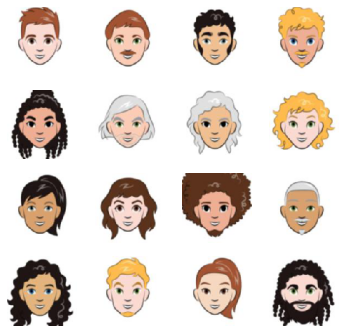

In [ ]:

test_data = load_images('/content/Anime to Real Face/Anime/Formatted Selected Animes Zip/')

n_samples=20

fig = plt.figure(figsize=(6,12))
    # real images
for i in range(16):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(test_data[i].astype("uint8"))
    plt.axis('off')

for i in range(test_data.shape[0]):
  test_data[i]=(test_data[i]-127.5)/127.5

semGAN_E = load_model('/content/drive/MyDrive/Sem GAN/Model/encoder_A_021600.h5',custom_objects={'InstanceNormalization':InstanceNormalization})
semGAN_D = load_model('/content/drive/MyDrive/Sem GAN/Model/decoder_A_021600.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

In [ ]:
semGAN_ = semGAN_D.predict(semGAN_E.predict(test_data[0:200]))

In [ ]:
semGAN_[0]

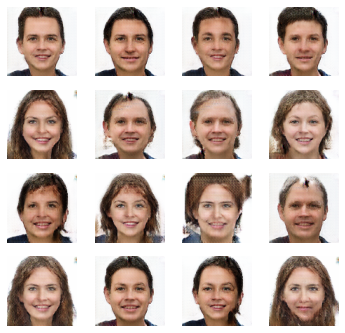

In [ ]:
for i in range(semGAN_.shape[0]):
  semGAN_[i]=(semGAN_[i]+1)/2

fig = plt.figure(figsize=(6,12))
    # real images
for i in range(16):
    fig.add_subplot(8, 4, i+1)
    plt.imshow(semGAN_[i])
    plt.axis('off')

In [ ]:
semGAN_[0]

## Reproducing Results from CycleGAN

In [ ]:
cycleGAN = load_model('/content/drive/MyDrive/saved models/e1.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

cyc_data = load_images()

for i in range(cyc_data.shape[0]):
  cyc_data[i]=(cyc_data[i]-127.5)/127.5

cyc_res = cycleGAN.predict(data)

for i in range(cyc_res.shape[0]):
  cyc_res[i]=(cyc_res[i]+1)/2

plot()